In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 512

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-29 10:27:04.584896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:27:04.627196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:27:04.627387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:27:04.663645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Early blast             615
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
3 Cell                  303
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

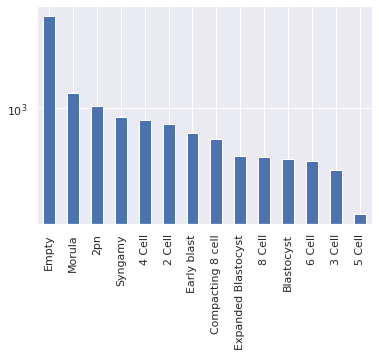

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
373         Early blast             5940
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Early blast',
 'Blastocyst',
 'Empty']

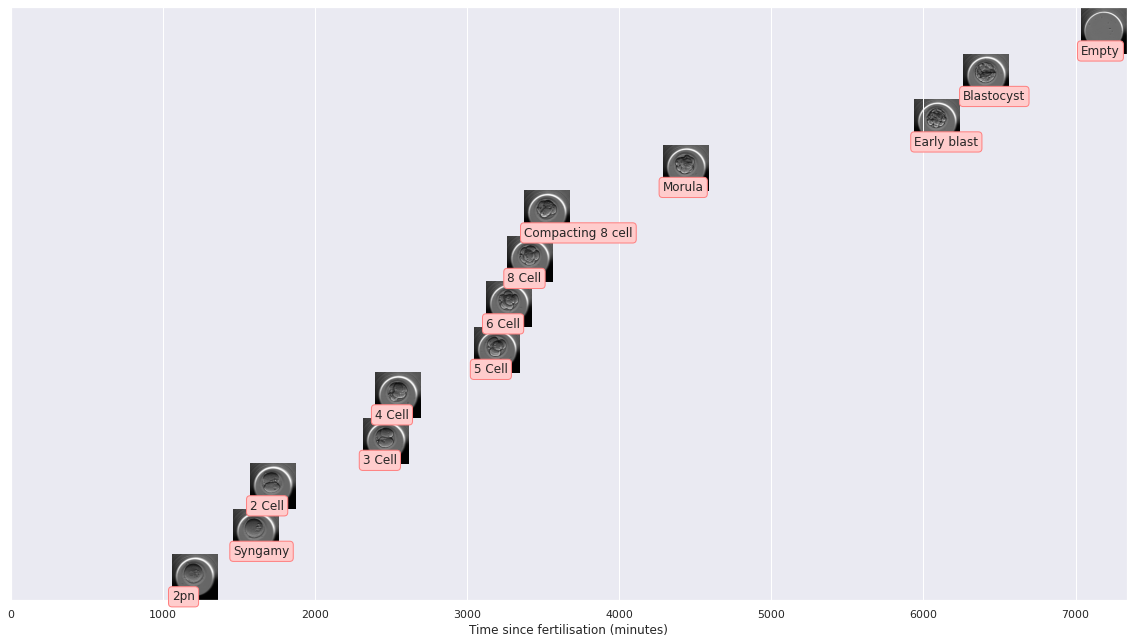

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [8]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),250))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),800))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W8_F0_6925.jpg,Expanded Blastocyst
1,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W1_F0_7696.jpg,Expanded Blastocyst
2,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W3_F0_6760.jpg,Expanded Blastocyst
3,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W4_F0_6984.jpg,Expanded Blastocyst
4,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W2_F0_6620.jpg,Expanded Blastocyst
...,...,...
731,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W3_F0_1654.jpg,2 Cell
732,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W1_F0_2267.jpg,2 Cell
733,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
734,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Morula                 800
2pn                    800
Empty                  800
Syngamy                667
4 Cell                 634
2 Cell                 589
Early blast            492
Compacting 8 cell      439
Expanded Blastocyst    315
8 Cell                 307
Blastocyst             299
6 Cell                 288
3 Cell                 242
5 Cell                 104
Name: class, dtype: int64

Empty                  250
Morula                 250
2pn                    208
Syngamy                167
4 Cell                 158
2 Cell                 147
Early blast            123
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
3 Cell                  61
5 Cell                  26
Name: class, dtype: int64

In [9]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.4, 1.5)
)


training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 6776 validated image filenames belonging to 14 classes.
Found 1803 validated image filenames belonging to 14 classes.


In [10]:
assert training.class_indices == validation.class_indices

In [11]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [12]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: 'Blastocyst',
 8: 'Compacting 8 cell',
 9: 'Early blast',
 10: 'Empty',
 11: 'Expanded Blastocyst',
 12: 'Morula',
 13: 'Syngamy'}

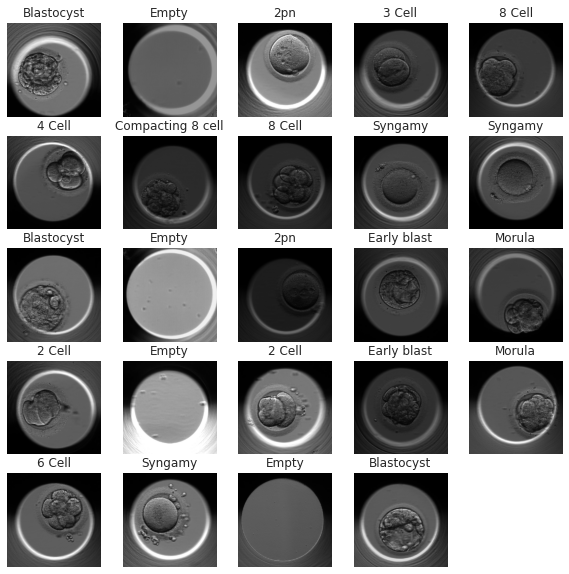

In [16]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

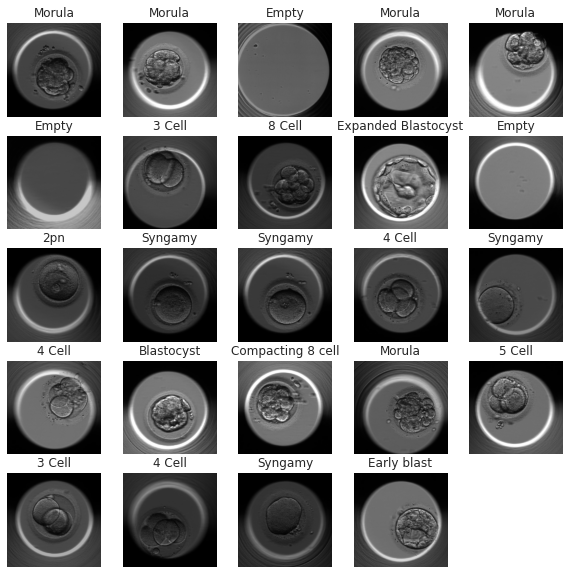

In [17]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [18]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-05-29 10:29:14.833898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 10:29:14.835679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:29:14.835904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 10:29:14.836035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                             

In [19]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 19.2 ms, sys: 391 µs, total: 19.5 ms
Wall time: 17.5 ms


In [21]:

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=10, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/14           ETA: ?s - 

2022-05-29 10:30:17.643733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-05-29 10:30:18.495681: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 2/500


0/14           ETA: ?s - 

Epoch 3/500


0/14           ETA: ?s - 

Epoch 4/500


0/14           ETA: ?s - 

Epoch 5/500


0/14           ETA: ?s - 

Epoch 6/500


0/14           ETA: ?s - 

Epoch 7/500


0/14           ETA: ?s - 

Epoch 8/500


0/14           ETA: ?s - 

Epoch 9/500


0/14           ETA: ?s - 

Epoch 10/500


0/14           ETA: ?s - 

Epoch 11/500


0/14           ETA: ?s - 

Epoch 12/500


0/14           ETA: ?s - 

Epoch 13/500


0/14           ETA: ?s - 

Epoch 14/500


0/14           ETA: ?s - 

Epoch 15/500


0/14           ETA: ?s - 

Epoch 16/500


0/14           ETA: ?s - 

Epoch 17/500


0/14           ETA: ?s - 

Epoch 18/500


0/14           ETA: ?s - 

Epoch 19/500


0/14           ETA: ?s - 

Epoch 20/500


0/14           ETA: ?s - 

Epoch 21/500


0/14           ETA: ?s - 

Epoch 22/500


0/14           ETA: ?s - 

Epoch 23/500


0/14           ETA: ?s - 

Epoch 24/500


0/14           ETA: ?s - 

Epoch 25/500


0/14           ETA: ?s - 

Epoch 26/500


0/14           ETA: ?s - 

Epoch 27/500


0/14           ETA: ?s - 

Epoch 28/500


0/14           ETA: ?s - 

Epoch 29/500


0/14           ETA: ?s - 

Epoch 30/500


0/14           ETA: ?s - 

Epoch 31/500


0/14           ETA: ?s - 

Epoch 32/500


0/14           ETA: ?s - 

Epoch 33/500


0/14           ETA: ?s - 

Epoch 34/500


0/14           ETA: ?s - 

Epoch 35/500


0/14           ETA: ?s - 

Epoch 36/500


0/14           ETA: ?s - 

Epoch 37/500


0/14           ETA: ?s - 

Epoch 38/500


0/14           ETA: ?s - 

Epoch 39/500


0/14           ETA: ?s - 

Epoch 40/500


0/14           ETA: ?s - 

Epoch 41/500


0/14           ETA: ?s - 

Epoch 42/500


0/14           ETA: ?s - 

Epoch 43/500


0/14           ETA: ?s - 

Epoch 44/500


0/14           ETA: ?s - 

Epoch 45/500


0/14           ETA: ?s - 

Epoch 46/500


0/14           ETA: ?s - 

Epoch 47/500


0/14           ETA: ?s - 

Epoch 48/500


0/14           ETA: ?s - 

Epoch 49/500


0/14           ETA: ?s - 

Epoch 50/500


0/14           ETA: ?s - 

Epoch 51/500


0/14           ETA: ?s - 

Epoch 52/500


0/14           ETA: ?s - 

Epoch 53/500


0/14           ETA: ?s - 

Epoch 54/500


0/14           ETA: ?s - 

Epoch 55/500


0/14           ETA: ?s - 

<AxesSubplot:>

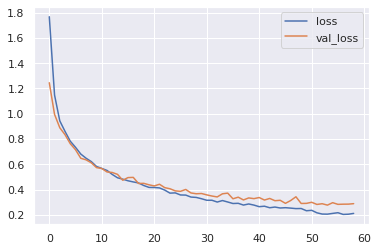

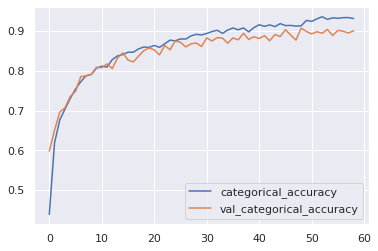

In [82]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [18]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [12, 7, 2, 10, 13, 9, 10, 3, 3, 8, 1, 10, 12, 2, 10, 10, 3, 2, 2, 3, 13, 4, 5, 1, 8, 11, 1, 3, 2, 3, 12, 1, 7, 1, 7, 12, 12, 7, 11, 12, 7, 11, 12, 12, 3, 9, 8, 12, 12, 1, 12, 9, 3, 8, 8, 10, 11, 1, 8, 7, 0, 1, 0, 2, 1, 7, 8, 8, 10, 10, 8, 1, 3, 1, 0, 10, 10, 13, 12, 0, 13, 0, 11, 1, 1, 0, 5, 13, 10, 8, 10, 1, 7, 0, 9, 13, 3, 12, 10, 1, 13, 12, 8, 3, 1, 12, 1, 9, 8, 10, 4, 8, 1, 5, 8, 8, 2, 10, 13, 0, 12, 1, 12, 2, 10, 8, 8, 5, 9, 12, 12, 9, 7, 1, 12, 2, 10, 11, 0, 10, 10, 9, 10, 10, 0, 12, 13, 12, 9, 12, 0, 13, 7, 10, 12, 0, 9, 3, 12, 0, 5, 8, 2, 1, 11, 3, 3, 12, 9, 10, 5, 1, 11, 6, 13, 7, 3, 5, 12, 8, 1, 8, 10, 10, 10, 13, 10, 5, 8, 1, 12, 13, 6, 2, 9, 3, 7, 3, 2, 12, 0, 3, 10, 13, 1, 1, 6, 1, 13, 8, 9, 13, 2, 3, 1, 3, 12, 1, 9, 10, 8, 9, 10, 6, 13, 9, 0, 6, 1, 5, 0, 10, 1, 13, 13, 3, 9, 8, 0, 3, 5, 13, 0, 0, 11, 9, 1, 13, 4, 2, 8, 5, 10, 11, 10, 1, 10, 12, 0, 13, 1, 1, 10, 10, 0, 13, 9, 8, 0, 11, 12, 5, 12, 3, 0, 10, 10, 12, 0, 13, 5, 2, 12, 0, 10, 12, 1, 8, 13, 13, 6, 0, 11, 1

In [83]:
y_pred = model.predict(validation)

4/4 [==============================] - 12s 3s/step


In [84]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    1803.000000
mean        0.878906
std         0.159302
min         0.266113
25%         0.813721
50%         0.957031
75%         0.995117
max         1.000000
dtype: float64

In [85]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
3,EmbryoLabeling/Labelers/train/2pn/M0776_S00534_W1_F0_1135.jpg,2pn,2pn,0.995117
8,EmbryoLabeling/Labelers/train/5 Cell/M0776_S00761_W3_F0_3190.jpg,5 Cell,5 Cell,0.849121
696,EmbryoLabeling/Labelers/train/2pn/M0776_S00470_W3_F0_857.jpg,2pn,2pn,0.713379
493,EmbryoLabeling/Labelers/train/Compacting 8 cell/M776_S0087_W3_F0_4656.jpg,Compacting 8 cell,Compacting 8 cell,0.919922
112,EmbryoLabeling/Labelers/train/Early blast/M0776_S00512_W8_F0_6301.jpg,Early blast,Early blast,0.436035
...,...,...,...,...
530,EmbryoLabeling/Labelers/train/Early blast/M0776_S00635_W1_F0_6460.jpg,Early blast,Early blast,0.597656
2052,EmbryoLabeling/Labelers/train/Empty/M3171_S00479_W12_F0_7721.jpg,Empty,Empty,NaN
8,EmbryoLabeling/Labelers/train/Morula/M0776_S00635_W3_F0_4775.jpg,Morula,Morula,0.849121
1003,EmbryoLabeling/Labelers/train/Empty/M0831_S00493_W2_F0_6909.jpg,Empty,Empty,0.956055


In [86]:
validation_df.groupby("class").confidence.median()

class
2 Cell                 0.939941
2pn                    0.952148
3 Cell                 0.929688
4 Cell                 0.957031
5 Cell                 0.954102
6 Cell                 0.955078
8 Cell                 0.918457
Blastocyst             0.906250
Compacting 8 cell      0.958984
Early blast            0.964844
Empty                  0.947266
Expanded Blastocyst    0.907715
Morula                 0.949219
Syngamy                0.950195
Name: confidence, dtype: float16

In [88]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.89      0.97      0.93       147
                2pn       0.99      0.86      0.92       208
             3 Cell       0.89      0.89      0.89        61
             4 Cell       0.92      0.93      0.92       158
             5 Cell       0.85      0.42      0.56        26
             6 Cell       0.79      0.85      0.82        72
             8 Cell       0.86      0.84      0.85        77
         Blastocyst       0.72      0.87      0.79        75
  Compacting 8 cell       0.93      0.73      0.82       110
        Early blast       0.85      0.85      0.85       123
              Empty       1.00      1.00      1.00       250
Expanded Blastocyst       0.93      0.80      0.86        79
             Morula       0.88      0.94      0.91       250
            Syngamy       0.85      0.98      0.91       167

           accuracy                           0.90      1803
          macro avg   

Text(30.499999999999993, 0.5, 'True')

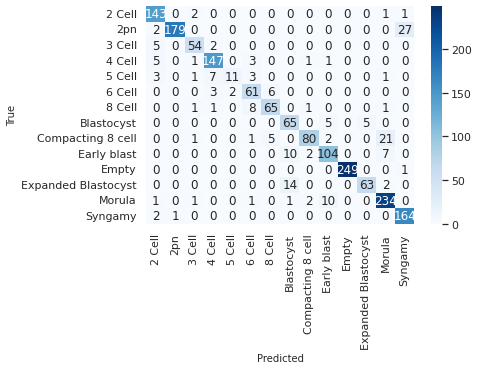

In [87]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [89]:
model.save(f"models/dense_{len(code2class)}_class.h5")

In [90]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

,filename,class
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,unknown
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,unknown
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,unknown
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,unknown
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,unknown
...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,unknown
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,unknown
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,unknown
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,unknown


In [91]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

Found 26557 validated image filenames belonging to 1 classes.


  0%|          | 0/51 [00:00<?, ?it/s]

52/52 [==============================] - 175s 3s/step


In [ ]:
predicted_codes = results.argmax(axis=1)
confidence = pd.Series(results.max(axis=1))
confidence.describe()

In [ ]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [ ]:
test_df["class"].value_counts()

In [ ]:
test_df

In [ ]:
test_df.to_csv("predictions.csv", index=False)

In [ ]:
pwd()